In [1]:
# Install all the libraries required for the workflow
!pip install eo-learn sentinelhub numpy matplotlib

  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ----- ---------------------------------- 3.1/24.5 MB 18.5 MB/s eta 0:00:02
   ---------- ----------------------------- 6.3/24.5 MB 16.8 MB/s eta 0:00:02
   ---------------- ----------------------- 10.2/24.5 MB 16.4 MB/s eta 0:00:01
   -------------------- ------------------- 12.8/24.5 MB 15.5 MB/s eta 0:00:01
   ------------------------- -------------- 15.7/24.5 MB 15.0 MB/s eta 0:00:01
   ----------------------------- ---------- 17.8/24.5 MB 14.8 MB/s eta 0:00:01
   --------------------------------- ------ 20.4/24.5 MB 13.9 MB/s eta 0:00:01
   ------------------------------------- -- 22.8/24.5 MB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 24.5/24.5 MB 13.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 13.7 MB/s eta 0:00:00
   ----


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# --- Standard Python libraries for everyday tasks ---
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

# --- Specialized libraries for Earth Observation ---
# These tools help us talk to the satellite data services and process the imagery.
from sentinelhub import SHConfig, BBox, CRS, DataCollection
from eolearn.core import EOTask, FeatureType
from eolearn.io import SentinelHubInputTask

# This is a handy tool for working with geographic shapes.
from shapely.geometry import Polygon

print("All necessary libraries are imported and ready to go! ")

All necessary libraries are imported and ready to go! 🚀


In [3]:
# --- CONFIGURE YOUR SENTINEL HUB CREDENTIALS ---
# TODO: Replace the placeholder text with your actual credentials.
config = SHConfig()
config.sh_client_id = "80f959d6-1900-438f-a09e-b751438bafa2"
config.sh_client_secret = "g8x3nTEgYPLL9njhVqKoV9pdPqpRr07I"

# A quick check to make sure the credentials have been updated.
if config.sh_client_id == "your_client_id" or config.sh_client_secret == "your_client_secret":
    print("✋ Please configure your Sentinel Hub client ID and secret in this cell.")
else:
    print("✅ Sentinel Hub credentials configured successfully.")

✅ Sentinel Hub credentials configured successfully.


In [4]:
# --- USER CONFIGURATION ---

# 1. Define the bounding box for your farmland.
# How to get coordinates: Go to Google Maps, find your farm, right-click on the
# corners of the area, and click the coordinates to copy them.
# The format is [bottom-left longitude, bottom-left latitude, top-right longitude, top-right latitude].
farmland_bbox = BBox(bbox=[75.836, 30.852, 75.842, 30.856], crs=CRS.WGS84)

# 2. Define the time range you want to analyze.
# Pro Tip: Satellite data can be huge! To avoid errors, it's best to start with a
# shorter time period (like 15 days). If the download still fails, try an even
# shorter window (like 7 days).
time_range = ('2025-07-01', '2025-07-15')

print(f"📍 Area of Interest (AOI): {farmland_bbox}")
print(f"📅 Time Range: {time_range}")

📍 Area of Interest (AOI): 75.836,30.852,75.842,30.856
📅 Time Range: ('2025-07-01', '2025-07-15')


C:\Users\sneha\AppData\Local\Temp\ipykernel_55908\2835855754.py:15: SHDeprecationWarning: The string representation of `BBox` will change to match its `repr` representation.
  print(f"📍 Area of Interest (AOI): {farmland_bbox}")


In [5]:

# Task 1 & 2 are unchanged...
# Think of these as recipes. Each one takes the data, performs a specific step,
# and passes the result to the next recipe.

# --- Recipe 1: Download the Satellite Photos ---
# This task connects to Sentinel Hub and downloads all the necessary light bands for your farm.
load_data_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L2A,
    bands=['B02', 'B03', 'B04', 'B05', 'B08', 'B11', 'B12', 'SCL'], # Spectral bands + Cloud info
    bands_feature=(FeatureType.DATA, 'BANDS'),
    resolution=10,
    maxcc=0.5, # We'll ignore images that are more than 50% cloudy
    config=config
)

# --- Recipe 2: Create a Filter for Clouds ---
# This task uses the 'SCL' band to find pixels that are clouds, shadows, or snow and marks them to be ignored.
class SclCloudMaskTask(EOTask):
    def execute(self, eopatch):
        scl_band = eopatch.data['BANDS'][..., -1]
        cloud_classes = [3, 8, 9, 10, 11] # Cloud Shadow, Clouds, Cirrus, Snow
        cloud_mask = np.isin(scl_band, cloud_classes)
        eopatch.mask['CLM'] = np.expand_dims(cloud_mask, axis=-1).astype(bool)
        return eopatch

# --- Recipe 3: Calculate Health & Soil Metrics ---
# This is the main science recipe. It calculates all 8 of our final metrics.
# Task 3: Calculate indices, now with MSI instead of NDWI
class CalculateIndicesTask(EOTask):
    def execute(self, eopatch):
        np.seterr(divide='ignore', invalid='ignore')
        bands = eopatch.data['BANDS'][..., :-1]

        blue, green, red, re, nir, swir1, swir2 = bands[..., 0], bands[..., 1], bands[..., 2], bands[..., 3], bands[..., 4], bands[..., 5], bands[..., 6]

        # --- Vegetation Indices ---
        ndvi, evi = (nir - red) / (nir + red), 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1))
        savi, ndre = ((nir - red) / (nir + red + 0.5)) * 1.5, (nir - re) / (nir + re)

        # --- Moisture Indices ---
        # THE FIX: Replace the old NDWI with the Moisture Stress Index (MSI)
        msi = swir1 / nir
        ndmi = (nir - swir1) / (nir + swir1)

        # --- Intelligent Soil Model ---
        bare_soil_mask = ndvi < 0.25
        bsi = ((swir1 + red) - (nir + blue)) / ((swir1 + red) + (nir + blue))
        predicted_soc_percent = np.clip(2.25 - 1.75 * bsi, 0, 10)
        predicted_soc_percent[~bare_soil_mask] = np.nan
        predicted_om_percent = predicted_soc_percent * 1.724

        # Stack all 8 results, now including MSI
        final_results = np.stack([ndvi, evi, savi, ndre, msi, ndmi, predicted_soc_percent, predicted_om_percent], axis=-1)

        eopatch.data['INDICES'] = final_results
        return eopatch

# Instantiate the tasks
scl_mask_task = SclCloudMaskTask()
calculate_indices_task = CalculateIndicesTask()

print("All data processing tasks are defined with the new Moisture Stress Index (MSI).")

All data processing tasks are defined with the new Moisture Stress Index (MSI).


In [6]:
# Let's kick off the analysis...
print("🏃 Executing the workflow step-by-step...")

# Initialize our data container.
result_eopatch = None

try:
    # --- Step 1: Download Data ---
    print("   - Downloading satellite data... this might take a moment. 🛰️")
    result_eopatch = load_data_task.execute(
        bbox=farmland_bbox,
        time_interval=time_range
    )
    print("   - Download complete.")

    # --- CRITICAL CHECK: Did we find any images? ---
    if not result_eopatch.timestamp:
        print("\n---------------------------------------------------------------------------")
        print("ERROR: No satellite images were found for your Area of Interest and Time Range.")
        print("SOLUTION: Try expanding your 'time_range' in Cell 4 (e.g., to a full month)")
        print("          or double-check your 'farmland_bbox' coordinates.")
        print("---------------------------------------------------------------------------")
        result_eopatch = None # This will stop the next cell from trying to create plots.
    else:
        print(f"   - Found and processed data for {len(result_eopatch.timestamp)} different dates.")

        # --- Step 2 & 3: Mask Clouds and Calculate Indices ---
        print("   - Creating a cloud mask to keep our data clean... ☁️")
        result_eopatch = scl_mask_task.execute(result_eopatch)

        print("   - Calculating all the farm health indices... 🌱")
        result_eopatch = calculate_indices_task.execute(result_eopatch)

        print("\n✅ All tasks executed successfully!")
        print(f"📦 Our final EOPatch container has the following data inside:\n{result_eopatch}")

except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")

🏃 Executing the workflow step-by-step...
   - Downloading satellite data... this might take a moment. 🛰️
   - Download complete.
   - Found and processed data for 1 different dates.
   - Creating a cloud mask to keep our data clean... ☁️
   - Calculating all the farm health indices... 🌱

✅ All tasks executed successfully!
📦 Our final EOPatch container has the following data inside:
EOPatch(
  bbox=BBox(((75.836, 30.852), (75.842, 30.856)), crs=CRS('4326'))
  timestamps=[datetime.datetime(2025, 7, 5, 5, 50, 25)]
  data={
    BANDS: numpy.ndarray(shape=(1, 45, 57, 8), dtype=float32)
    INDICES: numpy.ndarray(shape=(1, 45, 57, 8), dtype=float32)
  }
  mask={
    CLM: numpy.ndarray(shape=(1, 45, 57, 1), dtype=bool)
  }
)


C:\Users\sneha\AppData\Local\Temp\ipykernel_55908\469540889.py:17: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  if not result_eopatch.timestamp:
C:\Users\sneha\AppData\Local\Temp\ipykernel_55908\469540889.py:25: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  print(f"   - Found and processed data for {len(result_eopatch.timestamp)} different dates.")


C:\Users\sneha\AppData\Local\Temp\ipykernel_55908\3871530531.py:6: EODeprecationWarning: The attribute `timestamp` is deprecated, use `timestamps` instead.
  best_timestamp = result_eopatch.timestamp[best_timestamp_idx]


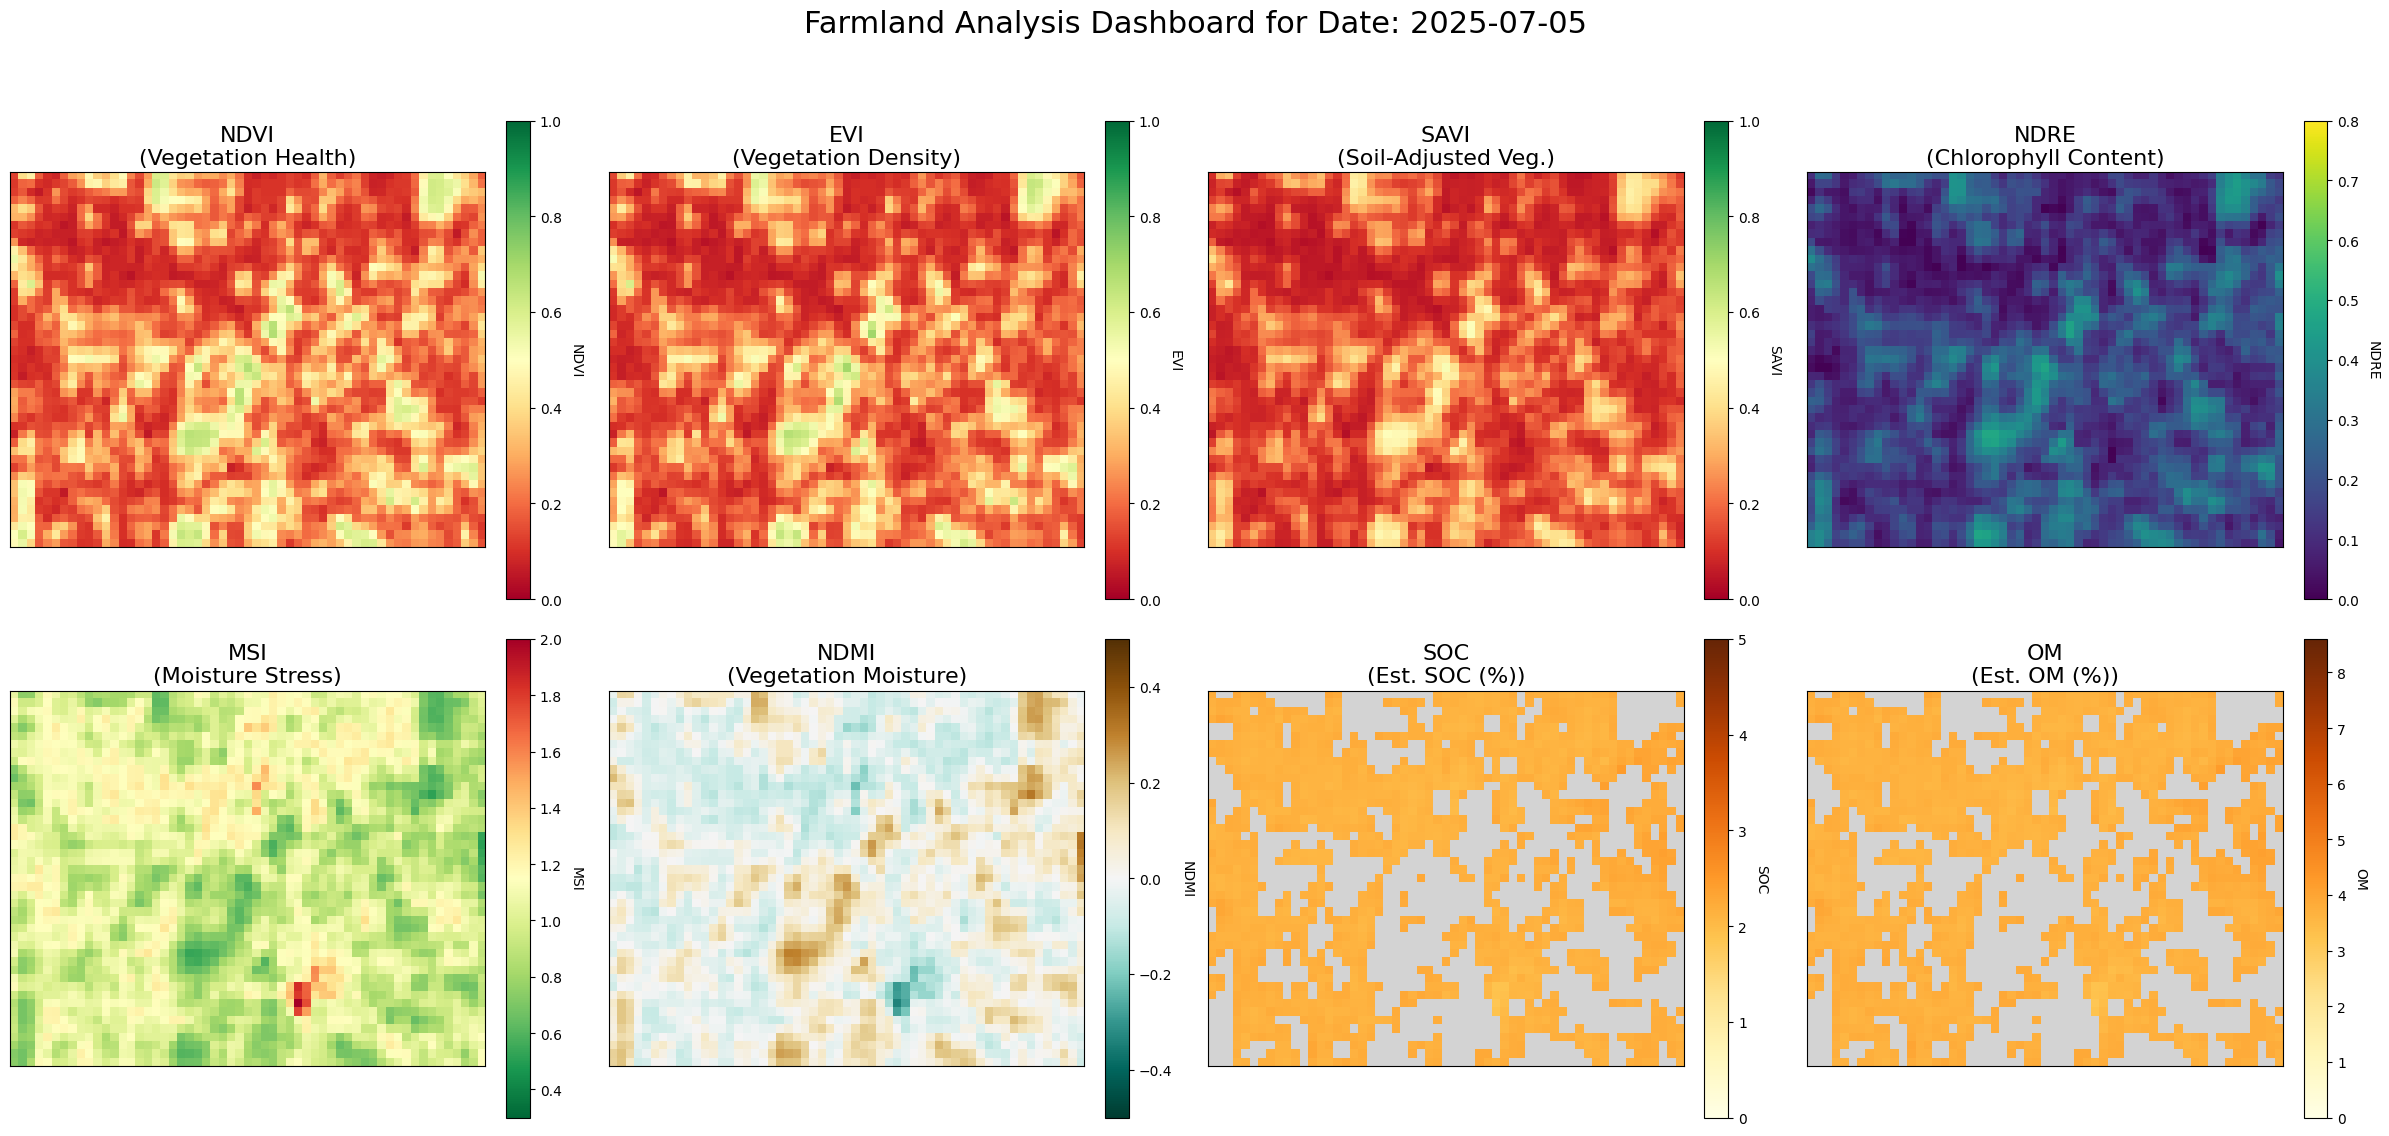

In [7]:
# This cell will only proceed if the workflow in the previous cell was successful
if result_eopatch:
    # --- 1. Data Preparation ---
    cloud_coverage = result_eopatch.mask['CLM'].mean(axis=(1, 2, 3))
    best_timestamp_idx = np.argmin(cloud_coverage)
    best_timestamp = result_eopatch.timestamp[best_timestamp_idx]
    indices_data = result_eopatch.data['INDICES'][best_timestamp_idx]

    # Define visualization parameters, now with MSI instead of NDWI
    index_info = {
        'NDVI': {'data': indices_data[..., 0], 'cmap': 'RdYlGn', 'vmin': 0, 'vmax': 1, 'label': 'Vegetation Health'},
        'EVI':  {'data': indices_data[..., 1], 'cmap': 'RdYlGn', 'vmin': 0, 'vmax': 1, 'label': 'Vegetation Density'},
        'SAVI': {'data': indices_data[..., 2], 'cmap': 'RdYlGn', 'vmin': 0, 'vmax': 1, 'label': 'Soil-Adjusted Veg.'},
        'NDRE': {'data': indices_data[..., 3], 'cmap': 'viridis', 'vmin': 0, 'vmax': 0.8, 'label': 'Chlorophyll Content'},
        'MSI':  {'data': indices_data[..., 4], 'cmap': 'RdYlGn_r','vmin': 0.3, 'vmax': 2.0, 'label': 'Moisture Stress'},
        'NDMI': {'data': indices_data[..., 5], 'cmap': 'BrBG_r',  'vmin': -0.5, 'vmax': 0.5, 'label': 'Vegetation Moisture'},
        'SOC':  {'data': indices_data[..., 6], 'cmap': 'YlOrBr',  'vmin': 0, 'vmax': 5, 'label': 'Est. SOC (%)'},
        'OM':   {'data': indices_data[..., 7], 'cmap': 'YlOrBr',  'vmin': 0, 'vmax': 8.6, 'label': 'Est. OM (%)'}
    }

    # --- 2. Create the Plots ---
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    fig.suptitle(f'Farmland Analysis Dashboard for Date: {best_timestamp.date()}', fontsize=22, y=0.96)
    axes = axes.ravel()

    for i, (name, info) in enumerate(index_info.items()):
        ax = axes[i]
        cmap = plt.get_cmap(info['cmap']).copy()
        if name in ['SOC', 'OM']:
            cmap.set_bad('lightgray', 1.)

        im = ax.imshow(info['data'], cmap=cmap, vmin=info['vmin'], vmax=info['vmax'])
        ax.set_title(f'{name}\n({info["label"]})', fontsize=16)
        ax.set_xticks([]); ax.set_yticks([])
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(name, rotation=270, labelpad=15)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

else:
    print("Skipping visualization because no data was successfully downloaded.")